# End-to-end-non-blind-deconvolution

This notebook builds an end-to-end non-blind-deconvolution train rgd optimizer using and torch==1.10 

## 1. Problem

Non blind deconvolution
we have blure image and the kernel that has been used to be blured, we need to get the laten image 
y = k ∗ x + n

* y ∈ R^m : blurred image 
* k ∈ R^l : corresponding blur kernel k
* x ∈ R^n : latent image  
* ∗ denotes the convolution operator
* n ∈ R^m : denotes an i.i.d. white Gaussian noise term with unknown standard deviation (i.e. noise level).

givin y and k, we need to estimate x

k is the psf of an eye of individuals having refractive vision problems. !


## 2. Data

The data we're using till now: *DATASET FROM HRTR: http://chaladze.com/l5/* 
//could be updated later


## 3. Evaluation

The evaluation is **PSNR** and **SSIM** //not commited yet
Now is also visualisation of output photos VS originl photos 'ground truth'
* evaluate our trained model using numbers:
  convolute the recoverd photo (output of our model) with the bluer-kernel and compare it with the input photo to the model (ground-truth*blure-kernel)
   comparing metods to use :MSE, SSIM


## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* We're generating dataset : blur kernel k, and n noise , and then y by ourself   
* 
* . 


In [ ]:
#path for dataset folder:
DATA_DIR = "dataFiles/Linnaeus 5 256X256/"

#num_params for psf - for sweet project that makes psf 
num_params=5 # or 20 later! 

#path for already trained models folder:
MODEL_DIR='trainedModels/'

#something for sweet project
SHIFT = True

### Get our workspace ready

* Reload all modules (except those excluded by %aimport) automatically now. '%autoreload'
* Reload all modules (except those excluded by %aimport) every time before executing the Python code typed. '%autoreload 2' ✅
* Import torch=1.10 ✅
* Make sure we're using a GPU ✅
* install lib  pydoe, torchsummary, torchmetrics, piq ✅


In [2]:
%load_ext autoreload
%autoreload 2 

In [3]:
%reload_ext autoreload

In [6]:
# #install necessary tools / either this cell or next
# ! pip install -r requirements.txt

In [4]:
# #install necessary tools
# !pip install pydoe -q
# !pip install torchsummary -q
# !pip install torchmetrics -q
# !pip install piq -q


# !pip install torch==1.10 
 

In [4]:
# Import necessary tools
import torch

# from __future__ import print_function, absolute_import
import torch
import os
# import scipy.io as sio
from torch.utils.data import Dataset, DataLoader
import numpy as np
# from data.make_kernel import kernel_sim_spline
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from pathlib import Path
# from operator import itemgetter
from skimage.color import rgb2gray
import pyDOE as doe # LHS
from scipy.stats.distributions import uniform
from tqdm import tqdm
# from skimage import util, filters
# from scipy import signal

from sweet.sweet import Sweet
from sweet.util.fft import shift, fft_conv

from sklearn.model_selection import train_test_split

#import the NNmodel for our training
from NNmodels.model_rgdn import OptimizerRGDN


# import the evalution function
from skimage.metrics import structural_similarity as ssim

print("pytorch version:", torch.__version__)
# 
# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if torch.cuda.is_available() else "not available :(")

pytorch version: 1.10.0+cu102
GPU available (YESSSS!!!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [5]:
#Make our dataset noise variant has been added  


fixed_params = {
    'pupil_diam' : 2.5,
    'A' : 0
    
    # order: S[-8,-4], A, C[-3,0], pupil_diam
    # for later: needs to be : S[-8,-2], C[-3,0], A[0,360 degree]
}

class BlurryImageDatasetOnTheFlySweet(Dataset):
    '''
    Implemented to use an eye's PSF from Sweet.
    PSF is not cropped.
    Convolution is perfomed with fft_conv.
    '''
    def __init__(self,
                 file_name_list,
                 is_rgb=True,
                 k_size=256,
                 patch_size=256,
                 max_num_images=None,
                 noise_level_interval:tuple =None,
                noise_level:float=None,
                rand_pfs=True):
        assert is_rgb == False, 'RGB images currently not supported'
        
        self.file_name_list = sorted(file_name_list)
        self.is_rgb = is_rgb
        self.k_size = k_size
        self.patch_size = 256
        self.params = []
        self.num_params = 0
        self.nl=0.0
        self.noise_level_interval=noise_level_interval
        self.noise_level=noise_level
        self.rand_pfs=rand_pfs
        self.psf_id=-1

        if max_num_images is not None and max_num_images < len(
                self.file_name_list):
            self.file_name_list = self.file_name_list[:max_num_images]
        
    @staticmethod
    def get_psf(S, A, C, pupil_diam):
        sweet = Sweet()
        sweet.set_eye_prescription(
            S = S,  
            A = A,
            C = C,  
        )
        sweet.set_experiment_params(
            pupil_diam = pupil_diam,  
            view_dist = 100.0,      
            canvas_size_h = 10.0,  
        )
        psf = sweet._psf()
        return psf
    
    
    def set_psf_params(self, params):
        self.params = params
        self.num_params = len(params)
      
        
    def params_random_init(self, num_params): #LHS      
        params = doe.lhs(4, samples=num_params) # order: S, A, C, pupil_diam
        loc =   [-8, fixed_params['A'], -3, fixed_params['pupil_diam']]
        scale = [4,  fixed_params['A'],  3, fixed_params['pupil_diam']]
        for j in range(4):
            if j == 1:
                params[:, j] = fixed_params['A']
            elif j == 3:
                params[:, j] = fixed_params['pupil_diam']
            else:
                params[:, j] = uniform(loc=loc[j], scale=scale[j]).ppf(params[:, j])
        params = params.tolist()
        for i in tqdm(range(num_params)):
            psf = BlurryImageDatasetOnTheFlySweet.get_psf(*params[i])
            psf = psf / psf.sum()        ###### ADD NORMALIZING
            params[i].append(psf)   
        self.params = params
        self.num_params = num_params

        
    def __len__(self):
        return len(self.file_name_list)

    
    def __getitem__(self, idx):
        #if the spf wanted in random (usually when training)
        if self.rand_pfs==True:
            i = np.random.choice(np.arange(self.num_params))
        #if not random, we'll take psf in order
        else:
            self.psf_id= ((self.psf_id+1)%(self.num_params)) #psf index in iterval [0,num_params[ 
            i=self.psf_id
#             print("psf_id ", i)
        k = self.params[i][-1]
        img_name = self.file_name_list[idx]
        sample = plt.imread(img_name)

        if sample.shape[0] < self.patch_size or sample.shape[
                1] < self.patch_size:
            return self.__getitem__((idx - 1) % (self.__len__()))
        patches = image.extract_patches_2d(sample,
                                           [self.patch_size, self.patch_size],
                                           max_patches=1)
        sample = patches[0, ...]
        sample = sample.astype(np.float32) / 255.0
        if not self.is_rgb:
            sample = rgb2gray(sample)
        y = fft_conv(sample, k)
#         print("y:",y.shape)
#         print("k:",k.shape)
#         print('len y',len(y))
#         print('len k',len(k))
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
        
#       #adding noise nl
        self.nl=0.0 #if no noise_level added it will be 0 
        if self.noise_level_interval is not None:
            self.nl = np.random.uniform(self.noise_level_interval[0], self.noise_level_interval[1])  #0.3% - 1.5%
#             print('noise_level_interval {}, {}'.format(self.noise_level_interval[0],self.noise_level_interval[1]))
        elif self.noise_level is not None:
            self.nl = self.noise_level
#             print('noise_level {}'.format(self.noise_level))
            
        y = y + self.nl * torch.randn_like(y)
#         print('nl {}'.format(self.nl))
        
        
        x_gt = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
        k = torch.tensor(k, dtype=torch.float32).unsqueeze(0)
        kt = torch.flip(k, [1, 2])
        return y, x_gt, k, kt     
    

In [6]:
#make costumed psf 
   
      
def costumed_psf(rand_values=True,
                 S=-4.0,
                 C=-1.5,
                 sphere_first_value=-8.0,
                 sphere_scale=4,
                 Cylinder_first_value=-3.0,
                 Cylinder_scale=3.0,
                 num_params=5):
    
    
    """
    Function to get costumed psf either by scale of Sphere and sylinder values, or by excact values for S,C.
    
    :param: rand_values: boolen to determin if psf parameters are randomly generated
    :param: S: defult=-4,sphere parameter psf, considered if rand_values=False
    :param: C: defult=0.5, Cylinder parameter psf, considered if rand_values=False
    :param: sphere_first_value: defult=-8, the first value S parameter takes
    :param: sphere_scale: defult=4, the scale that S can differ in 
    :param: Cylinder_first_value: defult=-3, the first value C parameter takes
    :param: Cylinder_scale: defult=3, the scale that C can differ in 
    :param: num_params: how many psf sample we want 
    
    :return: list of psf
    """
    
    #num_params :how many psf sample we want 
    params = doe.lhs(4, samples=num_params) # order: S, A, C, pupil_diam
    
    #P: pupil diameter = 2.5
    params[:, 3] = fixed_params['pupil_diam']
    
    #A: angel by degrees
    params[:, 1] = fixed_params['A']
    
    if rand_values== True:
        
        #S: is random number in interval [-8,-4]
        params[:, 0] = uniform(loc=sphere_first_value, scale=sphere_scale).ppf(params[:,0])

        #C: is random number in interval [-3,0]
        params[:, 2] = uniform(loc=Cylinder_first_value, scale=Cylinder_scale).ppf(params[:, 2])
    else:
        #S: is exact number givin
        params[:, 0] = S

        #C: is exact number given
        params[:, 2] = C
    
    params = params.tolist()

    for i in tqdm(range(num_params)):
        
        #get an 256*256 numpy array as psf
        print("*params[i]")
        print(*params[i])
        psf = BlurryImageDatasetOnTheFlySweet.get_psf(*params[i])
        psf = psf / psf.sum()        # ADD NORMALIZING
        # add the recieved numpy array psf to list 
        params[i].append(psf)
    
    
    return params



params=costumed_psf()        
      

    
for param in params:
    for p in param:
        print(str(p))
        print('\n')
    print('\n')
            
            

 20%|██        | 1/5 [00:00<00:00,  5.03it/s]

*params[i]
-4.0 0.0 -1.5 2.5
*params[i]
-4.0 0.0 -1.5 2.5


 60%|██████    | 3/5 [00:00<00:00,  6.23it/s]

*params[i]
-4.0 0.0 -1.5 2.5
*params[i]
-4.0 0.0 -1.5 2.5
*params[i]
-4.0 0.0 -1.5 2.5


100%|██████████| 5/5 [00:00<00:00, 10.37it/s]

-4.0


0.0


-1.5


2.5


[[0.00270009 0.00259145 0.00247398 ... 0.00235821 0.00284128 0.00275249]
 [0.0028153  0.00249595 0.00248674 ... 0.00232696 0.0026817  0.00277521]
 [0.00254937 0.00289326 0.00224913 ... 0.00239452 0.00294873 0.00216192]
 ...
 [0.0028152  0.00280463 0.00226378 ... 0.00243266 0.00286493 0.00232384]
 [0.00274025 0.00272073 0.00242113 ... 0.00232632 0.00277411 0.00271221]
 [0.00260174 0.00264301 0.00237559 ... 0.00224213 0.00296064 0.00265549]]




-4.0


0.0


-1.5


2.5


[[0.00270009 0.00259145 0.00247398 ... 0.00235821 0.00284128 0.00275249]
 [0.0028153  0.00249595 0.00248674 ... 0.00232696 0.0026817  0.00277521]
 [0.00254937 0.00289326 0.00224913 ... 0.00239452 0.00294873 0.00216192]
 ...
 [0.0028152  0.00280463 0.00226378 ... 0.00243266 0.00286493 0.00232384]
 [0.00274025 0.00272073 0.00242113 ... 0.00232632 0.00277411 0.00271221]
 [0.00260174 0.00264301 0.00237559 ... 0.00224213 0.00296064 0.00265549]]




-4.0


0.0


-1.5


2.5


[[0.00270009 0.00259145 0.

In [28]:
import numpy as np
np.random.seed(42)
# design = doe.lhs(2,1)
design = doe.lhs(4, samples=4) # order: S[-8,-4], A, C[-3,0], pupil_diam
# needs to be : S[-8,-2], C[-3,+3], A[0,360 degree]

loc =   [-8, fixed_params['A'], -3, fixed_params['pupil_diam']]
scale = [4,  fixed_params['A'],  3, fixed_params['pupil_diam']]
for j in range(4):
    if j == 1:
        design[:, j] = fixed_params['A']
    elif j == 3:
        design[:, j] = fixed_params['pupil_diam']
    else:
        design[:, j] = uniform(loc=loc[j], scale=scale[j]).ppf(design[:, j])
print(design.shape)
print(design)
# design=design.tolist()
# # print([len(a) for a in design])
# print(design)

# for i in tqdm(range(1)):
   
#     psf = BlurryImageDatasetOnTheFlySweet.get_psf(*design[i])
# #     print("psf\n",psf)
#     print("shape psf",psf.shape)
   
#     psf = psf / psf.sum()        ###### ADD NORMALIZING
# #     print("psf/psf.sum\n",psf)
#     design[i].append(psf)   
# design = design

# # print(design)


design2 = doe.lhs(4, samples=4) # order: S[-8,-4], A, C[-3,0], pupil_diam
# needs to be : S[-8,-2], C[-3,+3], A[0,360 degree]

loc =   [-8, fixed_params['A'], -3, fixed_params['pupil_diam']]
scale = [4,  fixed_params['A'],  3, fixed_params['pupil_diam']]
for j in range(4):
    if j == 1:
        design2[:, j] = fixed_params['A']
    elif j == 3:
        design2[:, j] = fixed_params['pupil_diam']
    else:
        design2[:, j] = uniform(loc=loc[j], scale=scale[j]).ppf(design2[:, j])
print(design2.shape)
print(design2)

(4, 4)
[[-7.62545988  0.         -2.20643729  2.5       ]
 [-5.39888499  0.         -2.45100454  2.5       ]
 [-6.84398136  0.         -0.61363127  2.5       ]
 [-4.16755736  0.         -1.48456163  2.5       ]]
(4, 4)
[[-5.98673504  0.         -0.5692309   2.5       ]
 [-6.53323711  0.         -1.07753384  2.5       ]
 [-7.90939357  0.         -1.73976935  2.5       ]
 [-4.98403375  0.         -2.71315351  2.5       ]]


In [16]:
def testrandseed():
    design = doe.lhs(2,5)
    design = doe.lhs(4, samples=5) # order: S[-8,-4], A, C[-3,0], pupil_diam
    # needs to be : S[-8,-2], C[-3,+3], A[0,360 degree]
    loc =   [0, 0, 5, 2.5]
    scale = [4,  0,  3, 2.5]
    for j in range(4):
        if j == 1:
            design[:, j] = 0
        elif j == 3:
            design[:, j] = 2.5
        else:
            design[:, j] = uniform(loc=loc[j], scale=scale[j]).ppf(design[:, j])
    print(design)

In [26]:
np.random.seed(42)
for i in range(5):
    design = doe.lhs(4, samples=1) # order: S[-8,-4], A, C[-3,0], pupil_diam
    print(design)

# testrandseed()

[[0.37454012 0.95071431 0.73199394 0.59865848]]
[[0.15601864 0.15599452 0.05808361 0.86617615]]
[[0.60111501 0.70807258 0.02058449 0.96990985]]
[[0.83244264 0.21233911 0.18182497 0.18340451]]
[[0.30424224 0.52475643 0.43194502 0.29122914]]


In [7]:
#make dataset into batches
#load data into batches, as aricle will do in batch of size(4) ! 
#article: https://arxiv.org/pdf/1804.03368.pdf

def get_dataloaders(data_files: list,
                    dataset: torch.utils.data.Dataset,
                    num_params: int,
                    params_filename: str,
                    batch_size:int =4,
                    shuffle:bool=True,
                    drop_last:bool=False,
                    noise_level_interval=None,
                    noise_level=None,
                   rand_pfs=True,
                   psf_params:list=None) -> (torch.utils.data.DataLoader, torch.utils.data.DataLoader):
    """
    Function to get dataloaders (works only with Sweet dataset).
    
    :param: data_files: list with paths to data
    :param: dataset: object of Dataset class
    :param: num_params: number of eye parameters generated on each epoch
    :param: params_filename: name of file to save psf-params generated during the training-sweet project
    :param: batch_size: nefers to the number of training samples used in one iteration
    :param: shuffle: If shuffle is set to True, then all the samples are shuffled and loaded in batches. Otherwise they are sent one-by-one without any shuffling.
    :param: drop_last: drop_last
    :param: tuple (), if noise is a percentage interval (%,%) defult set to None
    :pram: noise_level=float, if noise is fixed a percentage value (for test data) defult set to None
    :param: rand_pfs=True, chose psf parameters randomly
    :param: psf_params: parameters of psf if not random, list

    
    :return: dataloder
    """
    
    files_dataset = dataset(file_name_list=data_files,
                            is_rgb=False,
                            k_size=256,
                            max_num_images=None,
                            noise_level_interval=noise_level_interval,
                            noise_level=noise_level, rand_pfs=rand_pfs)
    if psf_params is not None:
        files_dataset.set_psf_params(psf_params)
    else: 
        files_dataset.params_random_init(num_params)
    
    
    data_loader = DataLoader(files_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
#     save_params(params_filename, files_dataset)
    
    return data_loader 



#save parameters for seet project
def save_params(filename, dataset):
    with open(filename, 'a') as f:
        for param in dataset.params:
            for p in param:
                f.write(str(p))
                f.write('\n')
            f.write('\n')

In [8]:
# Checkout our data
#How many images we have 

import os
from pathlib import Path
import numpy as np

#path for dataset folder:
# DATA_DIR = "/home/jovyan/Sarasweet/rgdn-optimizer-based-deconvolution/dataFiles/Linnaeus 5 256X256/"


#if train & test files in diffrent folders
train_dir = Path(os.path.join(DATA_DIR, 'train'))
test_dir = Path(os.path.join(DATA_DIR, 'test'))

train_files = list(train_dir.rglob('*.jpg'))
test_files = list(test_dir.rglob('*.jpg'))

print('We have:\nTrain files: {}\nTest files:{}'.format(len(train_files), len(test_files)))


# #if whole dataset (train+test) in same path folders
# data_path=Path(DATA_DIR)
# data_files = list(data_path.rglob('*.jpg'))
# print('We have dataset of {} files, that need to be splited into train and test.\n'.format(len(data_files)))


#train_files[:5]


We have:
Train files: 6000
Test files:2000


In [9]:
# put test_data_into_batches
np.random.seed(42)
test_loader = get_dataloaders(data_files=test_files[:100],
                               dataset=BlurryImageDatasetOnTheFlySweet,
                               num_params=num_params,
                               batch_size=5,
                               shuffle=False,
                               drop_last=False,
                               params_filename="file_to_save_parm_psf",
                               noise_level_interval=(0.003,0.015),
                               noise_level=None,
                              rand_pfs=False)



100%|██████████| 5/5 [00:00<00:00,  6.17it/s]


In [10]:
#load our saved model - need to be edited later

def load_trained_model(model: torch.nn.Module, 
                       opt: torch.optim.Optimizer,
                       name: str,
                      model_path:str) -> (torch.nn.Module, torch.optim):  
    """
    :param model: pytorch model to save
    :param opt: optimizer
    :param: model_name: name of the file where the model is stored
    :return: model with pretrained weights, optimizer
    """
    
    optimizer=opt
    path = model_path + name
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer

In [11]:
#evalute our model



#initiate optimizer and a model 
rgdn = OptimizerRGDN(num_steps=5, is_rgb=False)
# optimizer = torch.optim.Optimizer()
optimizer = torch.optim.Adam(rgdn.parameters(), lr=5e-5)

#load the model
model, optimizer=load_trained_model(model=rgdn,
                                    opt=optimizer,
                                    name='RGDN-SWEET-normed-param-d-GRAY-FFT-todel-after-server-crashed-noise-added-70',
                                    model_path=MODEL_DIR
                                   )

# RGDN-SWEET-normed-param-d-GRAY-FFT-todel-after-server-crashed-noise-added-30
model.eval()
1+1

2

In [12]:
np.random.seed(42)
#Test the first batch 
# model.set_num_steps(10)
# get the next iteration of dataset sample
y, x_gt, k, kt = next(iter(test_loader))

#get the recoverd photo from our model
res = model(y, k, kt)

In [13]:
#evalute function
def rmse(imageA, imageB):

    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    err= np.sqrt(err)
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def visual(y,x_gt,k,res):
    
    n_imgs=len(y)
    #from tensor to numpy
    x_hat=out_model_to_numpy(res,n_imgs)
    y_np,x_gt_np,k_np,kt_np=data_to_numpy(y,x_gt,k,kt)

    figsize: tuple=(25, 30)
    fig, axs = plt.subplots(nrows=n_imgs, ncols=5, figsize=figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

    for id_img in range(n_imgs):

                #turn off axis number
                for i in range(5):
                    axs[id_img][i].axis('off')

                #convolute the recovered photo with blure-kernel    
                res_conv_k= fft_conv(x_hat[id_img], k_np[id_img])
                #unite the datatype
                res_conv_k=res_conv_k.astype(np.float32)
                #calculate MSE and SSIM between ground_truth and blurred image  
                
                mgt = rmse(x_gt_np[id_img], y_np[id_img])
                sgt = ssim(x_gt_np[id_img], y_np[id_img])

                #calculate MSE and SSIM between recoverd img convoluted with the blur kernel K and blurred image            
                mrk = rmse(res_conv_k, y_np[id_img])
                srk = ssim(res_conv_k, y_np[id_img]) 


    #             compare_images(res_conv_k, y_np, "input to model vs. output*K")

                # better visualization psf-shift
                if SHIFT:
                    kj = shift(k_np[id_img])
                else:
                    kj = k_np[id_img[id_img]]

                #plot the images    
                axs[id_img][0].imshow(kj, cmap='gray')
                axs[id_img][0].set_title("PSF")

                axs[id_img][1].imshow(x_gt_np[id_img], cmap='gray')
                axs[id_img][1].set_title(  "(Gt, Blurred)\n"+("RMSE: %.4f, SSIM: %.4f" % (mgt, sgt))+ "\nGround truth")

                axs[id_img][2].imshow(y_np[id_img], cmap='gray')
                axs[id_img][2].set_title("Blurred img (input)")

                axs[id_img][3].imshow(res_conv_k, cmap='gray')
                axs[id_img][3].set_title(("(Recov*blur_Ker, Blurred)\n"+("RMSE: %.4f, SSIM: %.4f" % (mrk, srk)) ) + "\nRecovered*bluer_kernel")

                axs[id_img][4].imshow(x_hat[id_img], cmap='gray')
                axs[id_img][4].set_title("Recovered (output)")

In [14]:
#function from tensor to numpy array

def data_to_numpy(y, x_gt, k, kt) -> (np.array,np.array,np.array,np.array):  
    """
    return images in numpy array from dataset tensor.
    
    :param y: y-blurred image (x_gt*k)
    :param x_gt: x_ground truth
    :param: k: blur-kernel
    :param: kt: transpose of blur kernel
    :return: the same images as numpy array.
    """
    n_imgs=len(y)
    
    k_np=[]
    kt_np=[]
    y_np=[]
    x_gt_np=[]

    for id_img in range(n_imgs):
        #turn all to numpy array from tensors
        k_np.append(k[id_img].squeeze(0).cpu().numpy())
        y_np.append(y[id_img][0, :, :].cpu().numpy())
        x_gt_np.append(x_gt[id_img][0, :, :].cpu().numpy())
        kt_np.append(kt[id_img].squeeze(0).cpu().numpy())
    
    return y_np,x_gt_np,k_np,kt_np

def out_model_to_numpy(res,n_imgs)->(np.array):
    """
    return image in numpy array from output image tensor from model.
    :param res: output image tensor from model
    :param n_imgs: number of images,(size of batch)
    :return: the same image as numpy array.
    """
    
   
    x_hat=[]
    
    for id_img in range(n_imgs):
        x_hat.append(res[-1][id_img].detach().cpu().squeeze(0).numpy())
        
    return x_hat

    


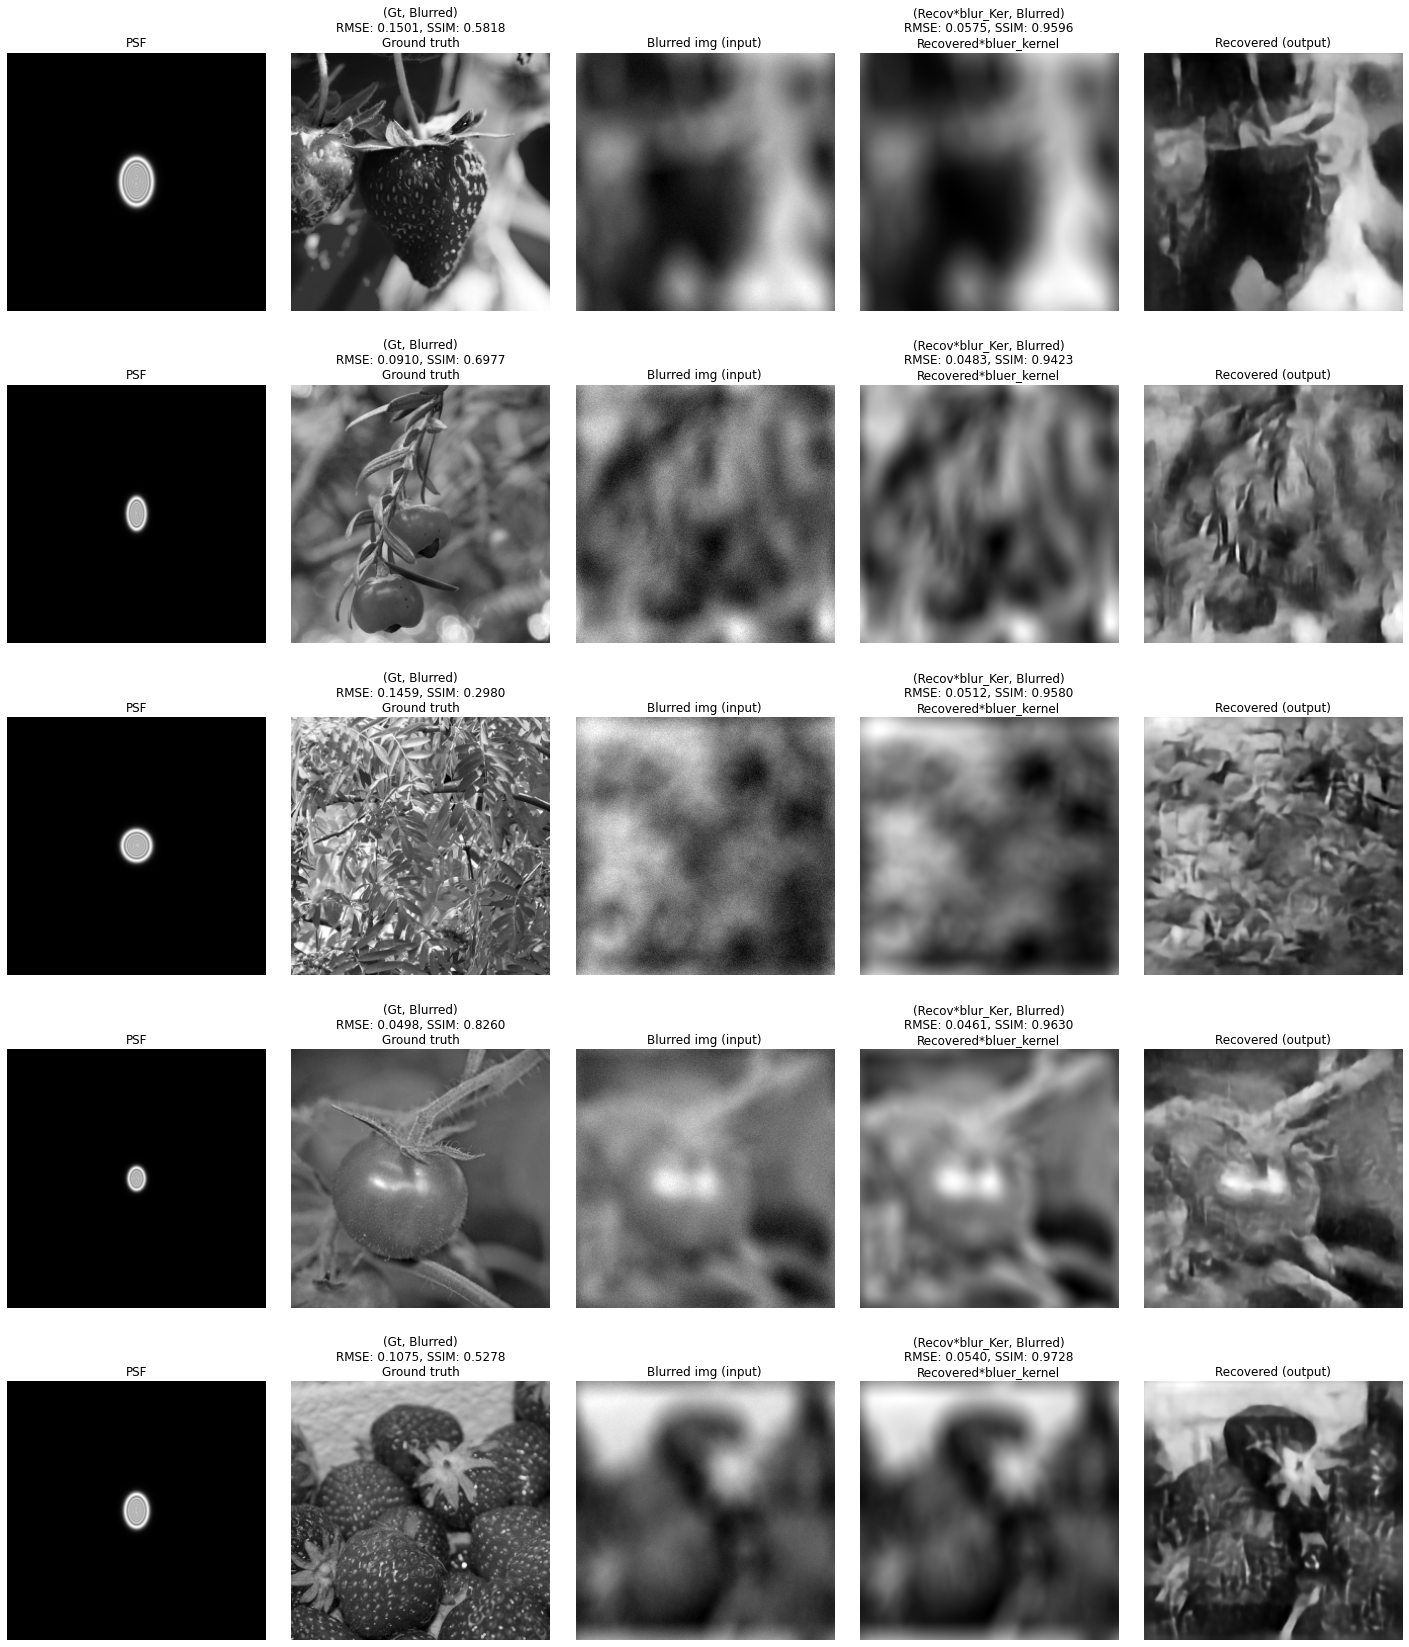

In [15]:
visual(y,x_gt,k,res)

In [16]:
# put test_data_into_batches
#data_Set without noise !
np.random.seed(42)
test_loader_without_noise = get_dataloaders(data_files=test_files[:100],
                               dataset=BlurryImageDatasetOnTheFlySweet,
                               num_params=num_params,
                               batch_size=5,
                               shuffle=False,
                               drop_last=False,
                               params_filename="file_to_save_parm_psf",
                               noise_level_interval=None,
                               noise_level=None,
                              rand_pfs=False)


100%|██████████| 5/5 [00:00<00:00, 12.00it/s]


In [17]:
np.random.seed(42)
#Test the first batch 
# get the next iteration of dataset sample
y, x_gt, k, kt = next(iter(test_loader_without_noise))

#get the recoverd photo from our model
res = model(y, k, kt)

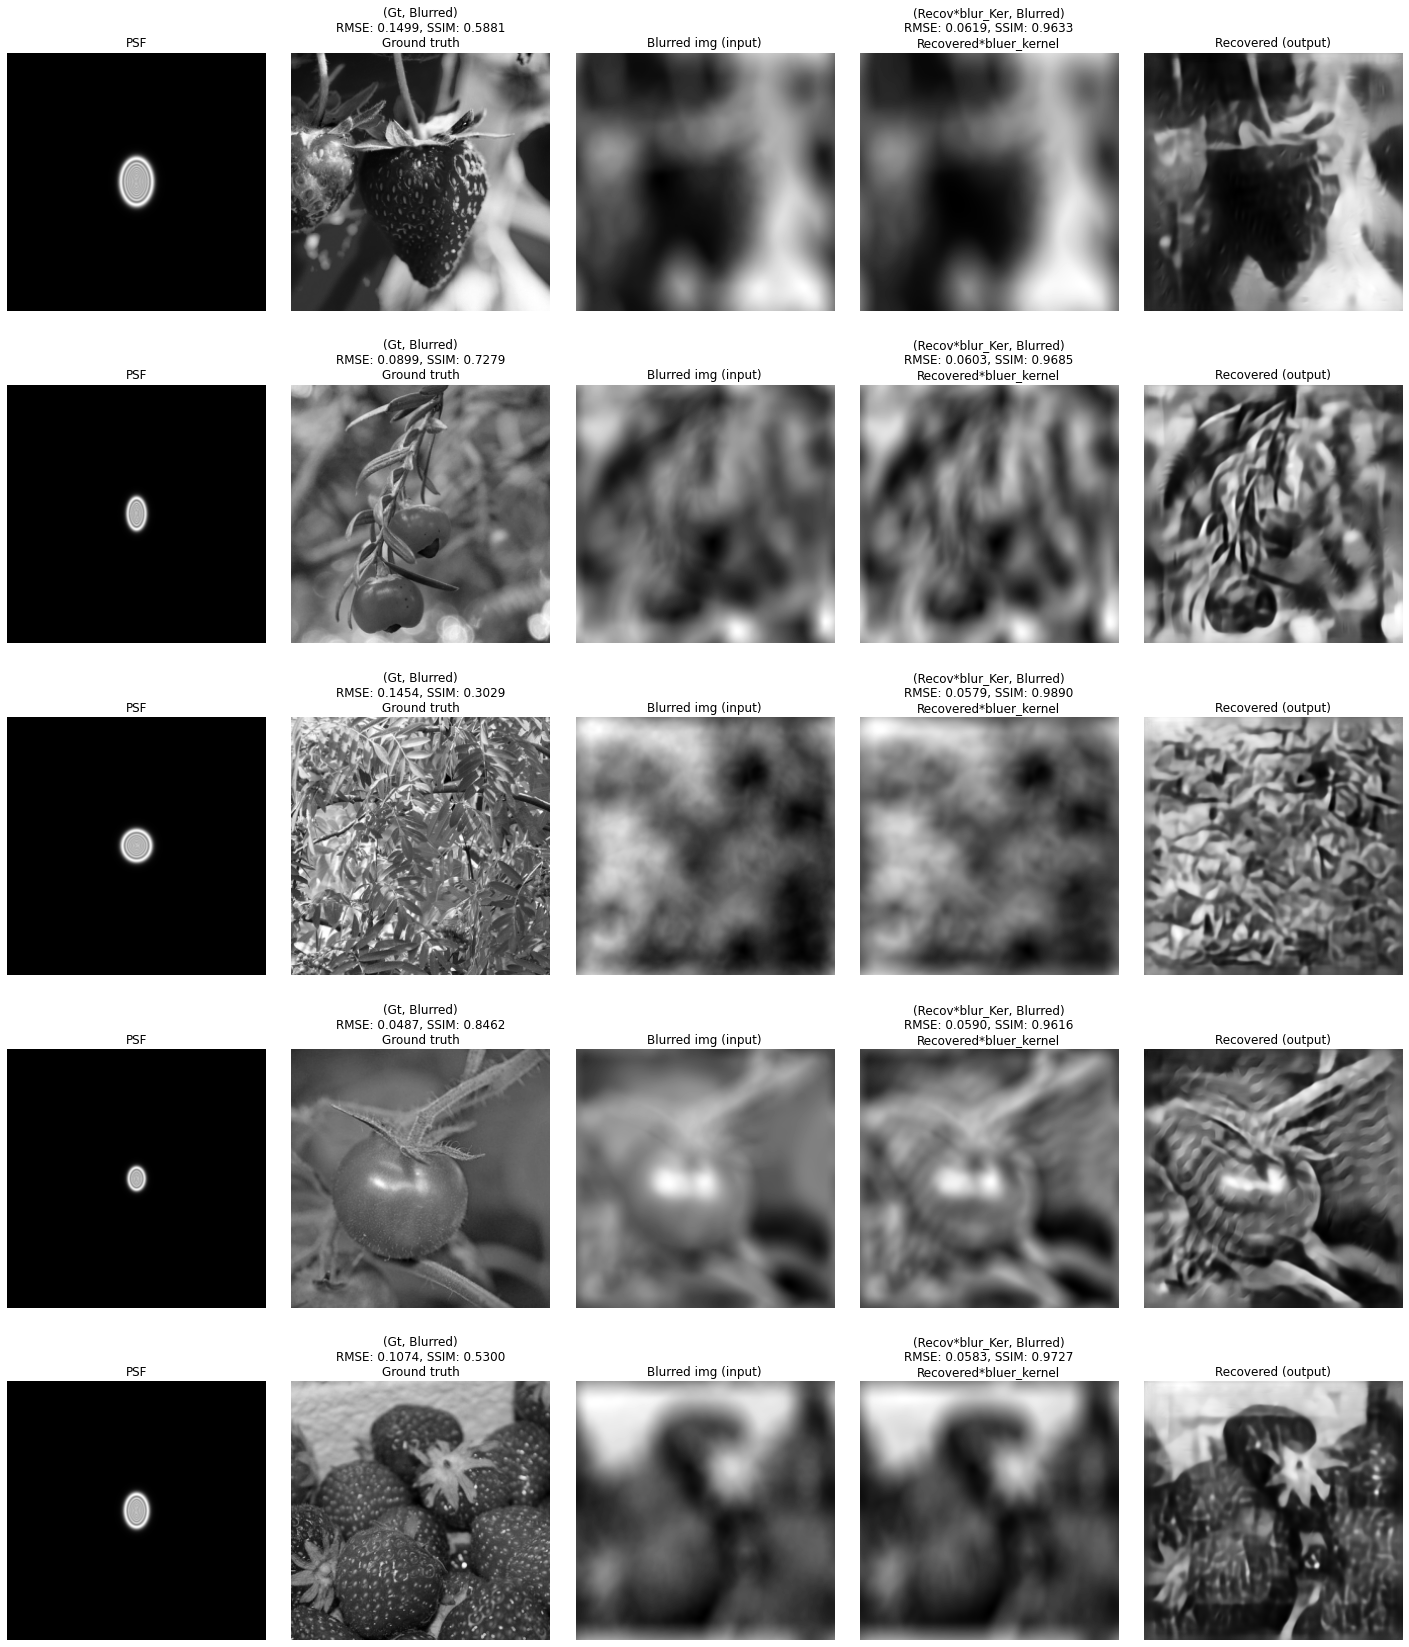

In [18]:
visual(y,x_gt,k,res)